In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import json

matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

In [2]:
# 07_overlapping_gene_ensembl_whole_gw_protein_coding: the orginal version

In [3]:
def is_distance_less_than_x(row1, row2, start , end, x ):
    row2_range = range(int(row2[start]), int(row2[end]))
    print(row1['Strand'])

    if row1['Strand'] == 1:
        start_row1_minus_end_row2 = abs(float(row1[start]) - float(row2[end]))
        start_row1_minus_start_row2 = abs(float(row1[start]) - float(row2[start]))
        start_row1_between_row2 = int(row1[start]) in row2_range
        return start_row1_minus_end_row2 < x or start_row1_minus_start_row2 < x or start_row1_between_row2
   
    elif row1['Strand'] == -1:
        end_row1_minus_start_row2 = abs(float(row1[end]) - float(row2[start]))
        end_row1_minus_end_row2 = abs(float(row1[end]) - float(row2[end]))
        end_row1_between_row2 = int(row1[end]) in row2_range
        return end_row1_minus_start_row2 < x or end_row1_minus_end_row2 < x or end_row1_between_row2
    else:
        raise Exception("The strand is neither 1 nor -1. Review is_distance_less_than_x!")

def add_element(dict, key, value):
    #https://stackoverflow.com/questions/33272588/appending-elements-to-an-empty-dictionary-of-lists-in-python
    if key not in dict:
        dict[key] = []
    if value not in dict[key]:  # Check if the value is not already in the list
        dict[key].append(value)

        
        
def overlap_list(biomart_df, start = 'Gene start (bp)', end = 'Gene end (bp)', x = 1000):
    filtered_objects = dict()

    for chromo in biomart_df['Chromosome/scaffold name'].unique():

    # select choromosom
        c1 = biomart_df[biomart_df['Chromosome/scaffold name'] == chromo]
#         # esstential gene in the chromosome
#         ess_gene_c1 = c1[c1['Gene name'].isin(ess_gene_list)]
        # Filter the DataFrame

        for i, row1 in c1.iterrows():
            for j, row2 in c1.iterrows():
                if i != j:
                    if is_distance_less_than_x(row1, row2, start = start, end = end, x = x):
                        add_element(filtered_objects, row1['Gene stable ID'], row2['Gene stable ID'])
                    else:
                        pass
    return filtered_objects
# Convert the dictionary into a list of tuples 
# then into df then melt datframe
def dict_to_df(example_dict):
    test_gene_overlap = []
    for key, value_list in example_dict.items():
        for value in value_list:
            test_gene_overlap.append((key, value))
    
    example_dict_data = pd.DataFrame(test_gene_overlap, columns=['Selected Gene', 'Overlapping Gene'])
    example_dict_data = example_dict_data.drop_duplicates()
    return example_dict_data

                    
def overlap_type(gene_1, gene_2, x = 1000):   

    # gene_1 and gene_2 are rows 
    if (float(gene_1['Strand'].iloc[0]) == 1) and (float(gene_2['Strand'].iloc[0]) == -1):
        distance_tss = abs(float(gene_1['Gene start (bp)'].iloc[0]) - float(gene_2['Gene end (bp)'].iloc[0]))
        other_distance_tss = abs(float(gene_1['Gene start (bp)'].iloc[0]) - float(gene_2['Gene start (bp)'].iloc[0]))

        if distance_tss <= x:
            return 2
        else:
            if other_distance_tss <= x:
                return 4
            else:
                return 5

    if (float(gene_1['Strand'].iloc[0]) == 1) and (float(gene_2['Strand'].iloc[0]) == 1):
        distance_tss = abs(float(gene_1['Gene start (bp)'].iloc[0]) - float(gene_2['Gene start (bp)'].iloc[0]))
        other_distance_tss_case1 = abs(float(gene_1['Gene start (bp)'].iloc[0]) - float(gene_2['Gene end (bp)'].iloc[0]))
        other_distance_tss_case2 = abs(float(gene_2['Gene start (bp)'].iloc[0]) - float(gene_1['Gene end (bp)'].iloc[0]))


        if distance_tss <= x:
            return 3
        else:

            if (other_distance_tss_case1 <= x) or (other_distance_tss_case2 <= x):
                return 1
            else:
                return 6
    
    if (float(gene_1['Strand'].iloc[0]) == -1) and (float(gene_2['Strand'].iloc[0]) == 1):
        distance_tss =  abs(float(gene_2['Gene start (bp)'].iloc[0]) - float(gene_1['Gene end (bp)'].iloc[0]))
        other_distance_tss = abs(float(gene_2['Gene start (bp)'].iloc[0]) - float(gene_1['Gene start (bp)'].iloc[0]))

        if distance_tss <= x:
            return 2
        else:
            if other_distance_tss <= x:
                return 4
            else:
                return 5
    if (float(gene_1['Strand'].iloc[0]) == -1) and (float(gene_2['Strand'].iloc[0]) == -1):
        distance_tss = abs(float(gene_1['Gene end (bp)'].iloc[0]) - float(gene_2['Gene end (bp)'].iloc[0]))
        other_distance_tss_case1 = abs(float(gene_1['Gene end (bp)'].iloc[0]) - float(gene_2['Gene start (bp)'].iloc[0]))
        other_distance_tss_case2 = abs(float(gene_2['Gene end (bp)'].iloc[0]) - float(gene_1['Gene start (bp)'].iloc[0]))

        if distance_tss <= x:
            return 3
        else:

            if (other_distance_tss_case1 <= x) or (other_distance_tss_case2 <= x):
                return 1
            else:
                return 6
                        


In [4]:
path = '../Data/CRISPRiChallenges/bioMart/'
biomart = pd.read_table(path + 'mart_export.txt', sep = ',', low_memory=False)
biomart.head()

,Gene stable ID,Gene stable ID version,Transcript stable ID,Transcript stable ID version,Gene type,Gene name,Gene description,Chromosome/scaffold name,Gene start (bp),Gene end (bp),Transcription start site (TSS),Strand,Transcript start (bp),Transcript end (bp)
0,ENSG00000210049,ENSG00000210049.1,ENST00000387314,ENST00000387314.1,Mt_tRNA,MT-TF,mitochondrially encoded tRNA-Phe (UUU/C) [Sour...,MT,577,647,577,1,577,647
1,ENSG00000211459,ENSG00000211459.2,ENST00000389680,ENST00000389680.2,Mt_rRNA,MT-RNR1,mitochondrially encoded 12S rRNA [Source:HGNC ...,MT,648,1601,648,1,648,1601
2,ENSG00000210077,ENSG00000210077.1,ENST00000387342,ENST00000387342.1,Mt_tRNA,MT-TV,mitochondrially encoded tRNA-Val (GUN) [Source...,MT,1602,1670,1602,1,1602,1670
3,ENSG00000210082,ENSG00000210082.2,ENST00000387347,ENST00000387347.2,Mt_rRNA,MT-RNR2,mitochondrially encoded 16S rRNA [Source:HGNC ...,MT,1671,3229,1671,1,1671,3229
4,ENSG00000209082,ENSG00000209082.1,ENST00000386347,ENST00000386347.1,Mt_tRNA,MT-TL1,mitochondrially encoded tRNA-Leu (UUA/G) 1 [So...,MT,3230,3304,3230,1,3230,3304


In [5]:
chromo1_22 = [str(num) for num in range(1, 23)]

biomart = biomart[biomart['Chromosome/scaffold name'].isin(chromo1_22+['X','Y'])]
biomart_protein_coding = biomart[biomart['Gene type'] == 'protein_coding']
proteinCodingGeneNoDup = biomart_protein_coding.drop_duplicates('Gene stable ID')


### above code are submitted in a python file in terminal and ran. the below code are analysising the GW run 

In [6]:
with open('../Data/CRISPRiChallenges/geneOverlap/all_gene_length_protein_coding.json', 'r') as file:
    GW_ensembl_protein_coding = json.load(file)
GW_ensembl_protein_coding_df = dict_to_df(GW_ensembl_protein_coding)
total_gene = list(GW_ensembl_protein_coding_df['Selected Gene']) + list(GW_ensembl_protein_coding_df['Overlapping Gene'])

print(f'There are {len(set(total_gene))} genes with at least one overlap.')
print(f'This {100*(len(set(total_gene))/20033)} percent of total genes.')



There are 7218 genes with at least one overlap.
This 36.030549593171266 percent of total genes.


In [7]:
# merge Overlapping gene
GW_ensembl_protein_coding_df = pd.merge(GW_ensembl_protein_coding_df,
         proteinCodingGeneNoDup[['Gene stable ID', 'Strand', 'Gene name','Gene start (bp)', 
                                'Gene end (bp)']].rename(columns = {'Gene stable ID': 'Overlapping Gene',
                                                            'Strand': 'Overlapping Strand', 
                                                              'Gene name': 'Overlapping Gene name',
                                                              'Gene start (bp)': 'Overlapping Gene start (bp)', 
                                                              'Gene end (bp)': 'Overlapping Gene end (bp)' }))



In [8]:
# merge Selected gene
GW_ensembl_protein_coding_df = pd.merge(GW_ensembl_protein_coding_df,
         proteinCodingGeneNoDup[['Gene stable ID', 'Strand', 'Gene name','Gene start (bp)', 
                                'Gene end (bp)']].rename(columns = {'Gene stable ID': 'Selected Gene',
                                                            'Strand': 'Selected Strand', 
                                                              'Gene name': 'Selected Gene name',
                                                              'Gene start (bp)': 'Selected Gene start (bp)', 
                                                              'Gene end (bp)': 'Selected Gene end (bp)' }))
    

In [9]:
for index, row in GW_ensembl_protein_coding_df.iterrows():
    gene_name_1 = row['Selected Gene']
    gene_name_2 = row['Overlapping Gene']
    gene_name_1_row = proteinCodingGeneNoDup[proteinCodingGeneNoDup['Gene stable ID'].isin([gene_name_1])]
    gene_name_2_row = proteinCodingGeneNoDup[proteinCodingGeneNoDup['Gene stable ID'].isin([gene_name_2])]
    overlap_type_number = overlap_type(gene_name_1_row, gene_name_2_row)
    GW_ensembl_protein_coding_df.loc[index,'overlap type'] = overlap_type_number


In [10]:
GW_ensembl_protein_coding_df.head()

,Selected Gene,Overlapping Gene,Overlapping Strand,Overlapping Gene name,Overlapping Gene start (bp),Overlapping Gene end (bp),Selected Strand,Selected Gene name,Selected Gene start (bp),Selected Gene end (bp),overlap type
0,ENSG00000099721,ENSG00000092377,1,TBL1Y,6910686,7101970,-1,AMELY,6865918,6911752,5.0
1,ENSG00000092377,ENSG00000099721,-1,AMELY,6865918,6911752,1,TBL1Y,6910686,7101970,5.0
2,ENSG00000292345,ENSG00000292338,-1,DHRSX,2219506,2502805,-1,ZBED1,2486414,2500976,6.0
3,ENSG00000132952,ENSG00000189403,-1,HMGB1,30456704,30617597,1,USPL1,30617693,30660770,2.0
4,ENSG00000189403,ENSG00000132952,1,USPL1,30617693,30660770,-1,HMGB1,30456704,30617597,2.0


In [11]:
GW_ensembl_protein_coding_df.to_csv('../Data/CRISPRiChallenges/geneOverlap/GW_ensembl_protein_coding_df_1kb.csv', 
                                   index = False)


In [14]:
graph_pathout = '../Figure/Figure 2/Individual Figures/'


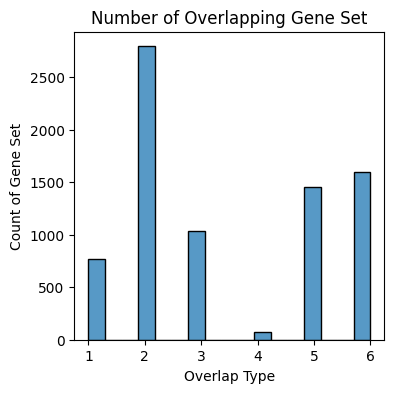

In [15]:
plt.subplots(figsize=(4, 4))

sns.histplot(GW_ensembl_protein_coding_df, x="overlap type")
plt.title('Number of Overlapping Gene Set')
plt.xlabel('Overlap Type')
plt.ylabel('Count of Gene Set')
plt.savefig(graph_pathout + "Overlapping Gene Set.pdf", dpi=300, bbox_inches='tight')


In [16]:
GW_ensembl_protein_coding_df["overlap type"].value_counts()

overlap type
2.0    2792
6.0    1601
5.0    1456
3.0    1038
1.0     765
4.0      74
Name: count, dtype: int64

In [17]:
overlappingGene = GW_ensembl_protein_coding_df['Selected Gene'].tolist() + GW_ensembl_protein_coding_df['Overlapping Gene'].tolist()
print(f'number of gene with at least one overlap type: {len(set(overlappingGene))}')

number of gene with at least one overlap type: 7218


In [18]:
overlappingGeneType23 = GW_ensembl_protein_coding_df[GW_ensembl_protein_coding_df['overlap type'].isin([2,3])]
overlappingGeneType23 = overlappingGeneType23['Selected Gene'].tolist() + overlappingGeneType23['Overlapping Gene'].tolist()
print(f'number of gene with at least one overlap type in Type 2 or 3: {len(set(overlappingGeneType23))}')

number of gene with at least one overlap type in Type 2 or 3: 3478


In [19]:
print(f'number of total gene: {len(proteinCodingGeneNoDup["Gene stable ID"])}')


number of total gene: 20033


In [20]:
geneNumberOverlap ={'Total Protein Coding Gene': len(proteinCodingGeneNoDup["Gene stable ID"]),
                     'Gene with Overlap': len(set(overlappingGene)),
                    'Gene with Overlap Type 2 or 3': len(set(overlappingGeneType23))
                    }


geneNumberOverlap = {"Gene Type": ['Total Protein Coding Gene', 'Gene with Overlap', 'Gene with Overlap Type 2 or 3'],
                    "Count of Gene": [len(proteinCodingGeneNoDup["Gene stable ID"]), len(set(overlappingGene)), len(set(overlappingGeneType23))]}
                                          
                                          



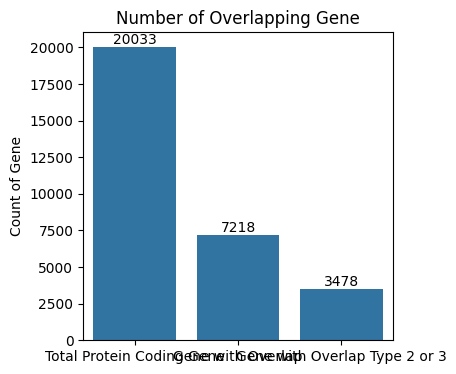

In [21]:
plt.subplots(figsize=(4, 4))

g = sns.barplot(x='Gene Type', y='Count of Gene', data=pd.DataFrame(geneNumberOverlap))
plt.xlabel('')
g.bar_label(g.containers[0], labels=geneNumberOverlap['Count of Gene'])
plt.title('Number of Overlapping Gene')
plt.savefig(graph_pathout + "Overlapping Gene.pdf", dpi=300, bbox_inches='tight')
